In [9]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

Hiển thị hình ảnh gốc

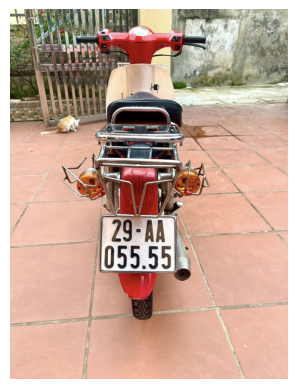

In [10]:
image = cv2.imread('/NguyenPham/HK3-2023_2024/Project/NDBSX/src/Yolo8m/dataset/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

Load mô hình và nhận dạng

In [11]:
model = YOLO('/NguyenPham/HK3-2023_2024/Project/NDBSX/src/Yolo8n/NDKBS/train/weights/best_KBS_8n.pt')
result = model(image)


0: 640x480 1 Plate, 402.7ms
Speed: 14.0ms preprocess, 402.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Hiển thị hình ảnh đã nhận dạng có box

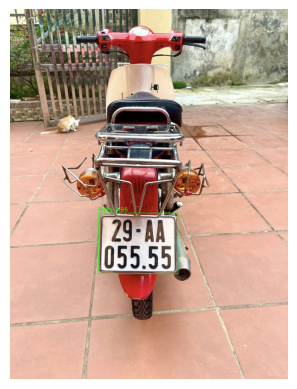

In [12]:
result = result[0]
# Vẽ bounding boxes lên ảnh
for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = box.conf[0]
    cls = box.cls[0]

    # Vẽ bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Ghi nhãn cho bounding box
    label = f'{model.names[int(cls)]} {conf:.2f}'
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

# Hiển thị ảnh với bounding boxes bằng matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()

Xử lý cắt khung biển số

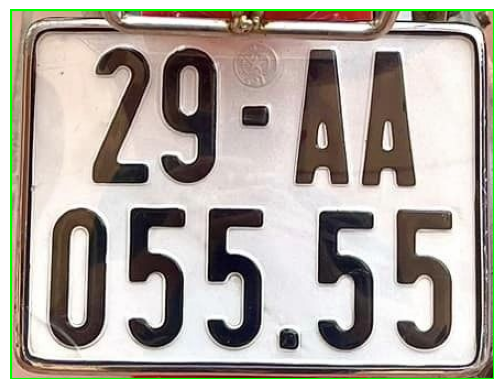

In [13]:
ROIs = []

# Ngưỡng độ tin cậy
CONFI_THRES = 0.7

# Lấy thông tin hộp giới hạn từ kết quả YOLOv8
for results in result:
    boxes = results.boxes.data.tolist()
    for box in boxes:
        x_min, y_min, x_max, y_max, confidence, cls = box
        if confidence > CONFI_THRES:
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
            # Cắt vùng ROI từ hình ảnh gốc
            roi = image[y_min:y_max, x_min:x_max]
            ROIs.append(roi)
img_roi = ROIs[0]
# Hiển thị từng ảnh đã cắt
plt.imshow(img_roi)
plt.axis('off')  
plt.show()

Nhận dạng ký tự

In [14]:
char_recognition_model = YOLO('/NguyenPham/HK3-2023_2024/Project/NDBSX/src/Yolo8m/runs/detect/train/weights/best_char8m.pt')
results_char = char_recognition_model(img_roi)


0: 512x640 1 0, 1 2, 4 5s, 1 9, 2 As, 2059.7ms
Speed: 8.0ms preprocess, 2059.7ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 640)


Chuỗi sau khi sắp xếp:  29-AA 055.55


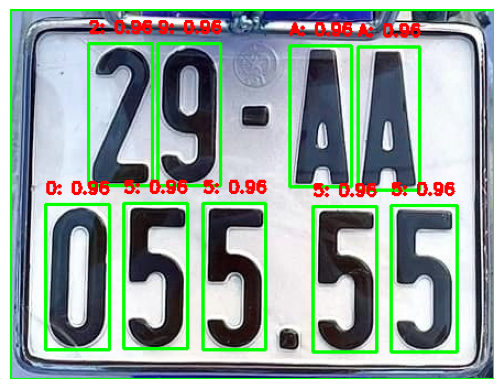

In [15]:
detections = []
for result in results_char:
    boxes = result.boxes.xyxy  # Lấy tọa độ bounding boxes
    scores = result.boxes.conf  # Lấy ngưỡng tin cậy (confidence scores)
    classes = result.boxes.cls  # Lấy các class id
    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)
        cls = int(cls)  # Chuyển đổi class id sang integer
        detections.append((x1, y1, x2, y2, score, cls))

# Xác định ngưỡng để xác định khi nào các bounding boxes nằm trên cùng một dòng
line_threshold = 10

# Nhóm các bounding boxes vào các dòng dựa trên tọa độ y
lines = []
detections.sort(key=lambda x: x[1])  # Sắp xếp các bounding boxes theo tọa độ y1 (từ trên xuống dưới)
current_line = []
current_y = detections[0][1] # Lấy tọa độ y1 của bounding box đầu tiên làm chuẩn cho dòng hiện tại.

for detection in detections:
    x1, y1, x2, y2, score, cls = detection
    # Kiểm tra xem bounding box hiện tại có nằm trên cùng một dòng với dòng hiện tại không
    if abs(y1 - current_y) <= line_threshold:
        current_line.append(detection)
    else:
        lines.append(current_line)
        current_line = [detection] # Bắt đầu một dòng mới với bounding box hiện tại.
        current_y = y1

if current_line:
    lines.append(current_line)

# Sắp xếp các bounding boxes trong mỗi dòng theo trục x và tạo chuỗi kết quả
result_string = ""
for line in lines:
    line.sort(key=lambda x: x[0])  # Sắp xếp theo x1 trong mỗi dòng (trái qua phải)
    for (x1, y1, x2, y2, score, cls) in line:
        if cls in char_recognition_model.names:
            label = f'{char_recognition_model.names[cls]}'
            result_string += label
        else:
            print(f'Warning: Class id {cls} not found in model names.')

#thêm '-' & '.' vào chuỗi đã sắp xếp.
formatted_result_string = result_string[:2] + '-' + result_string[2:4] + ' ' + result_string[4:7] + '.' + result_string[7:]

print("Chuỗi sau khi sắp xếp: ", formatted_result_string)

# Vẽ các bounding boxes theo thứ tự đã sắp xếp
for line in lines:
    for (x1, y1, x2, y2, score, cls) in line:
        if cls in char_recognition_model.names:
            label = f'{char_recognition_model.names[cls]}: {confidence:.2f}'
            cv2.rectangle(img_roi, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vẽ hình chữ nhật
            cv2.putText(img_roi, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)  # Thêm nhãn

# Hiển thị hình ảnh
plt.imshow(cv2.cvtColor(img_roi, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()